# Video Search Webapp with Azure Content Understanding
## Objective
This document will guide you through how to run and use the Video Search Webapp sample as well as providing the backend server.
1. Set up Azure resources and acquire the necessary endpoints, API keys, API versions, and deployment names.
2. Build and run node.js server that serves the frontend webapp.
3. Launch and port forward the backend server through this Python Notebook.


## Pre-requisites
### Follow the overall Azure role setup for your resources
1. [Setup Readme](https://github.com/Azure-Samples/azure-ai-search-with-content-understanding-python/blob/main/README.md)
2. Install az login using `curl -sL https://aka.ms/InstallAzureCLIDeb | sudo bash`
3. Run `az login --use-device-code` or `azd auth login`
### Environment Variable Setup for Azure OpenAI
Populate your .env file with these endpoints and other info.
1. Azure OpenAI Resource's Endpoint
   - **Where to find it**: In the Azure Portal, go to your **Azure OpenAI resource** > **Keys and Endpoint** tab.
   - **Example**: "https://<your-resource-name>.openai.azure.com/"

2. Completions Deployment Name
   - **Where to find it**: Click on **Explore Azure AI Studio** on the Overview page of the Azure OpenAI resource, Under **Deployments**, find the deployment name for the Completions model.
   - **Example**: "gpt4o"

3. Completions API Version
   - **Where to find it**: At the end of the Target URI in the **Deployments** page in **Azure AI Studio**.
   - **Example**: "2024-08-01-preview"

4. Embeddings Deployment Name
   - **Where to find it**: Similar to the Completions deployment, find this under **Deployments**.
   - **Example**: "text-embedding-ada-002"

5. Embeddings API Version
   - **Where to find it**: At the end of the Target URI in the **Deployments** page in **Azure AI Studio**.
   - **Example**: "2023-05-15"

## Install Packages

In [ ]:
%pip install -r ../requirements.txt

## Build Webapp

In [ ]:
import os
from pathlib import Path
import subprocess

# Get the current working directory of the notebook
notebook_path = Path().resolve()

# Print the notebook's working directory
print("Notebook working directory:", notebook_path)

# Change the current working directory to the notebook's directory
# This is necessary to ensure that the script runs in the correct context
# and can access the required files and folders.
# Note: This is a workaround for Jupyter Notebook's behavior of not
# automatically setting the working directory to the notebook's location.
# This is especially important when running the script in a Jupyter Notebook
# environment where the working directory may not be set to the notebook's location.
os.chdir(notebook_path)

# Change the current working directory to the Node.js project folder
os.chdir("../nodejs/video-search-app")

# Verify the current working directory
print("Current working directory:", os.getcwd())

# Update and install Node.js, npm
os.system("sudo apt update")
os.system("sudo apt install -y nodejs npm")

# Install dependencies
os.system("npm install --legacy-peer-deps")

# Build the project
os.system("npm run build")

# Start the Next.js server using subprocess
# This runs in the background and won't block the notebook
with open("server.log", "w") as log_file:
    process = subprocess.Popen(
        ["npm", "run", "start"],
        stdout=log_file,
        stderr=subprocess.STDOUT
    )

print(f"Started Next.js server (PID: {process.pid}). Logs are in server.log.")

# Change the current working directory back to the notebooks folder
os.chdir("../../notebooks/")

After running this code, navigate to the Ports tab next to Terminal, you should see the webapp being hosted at port 3000, the "Forwarded Address" is where you can find the webapp.
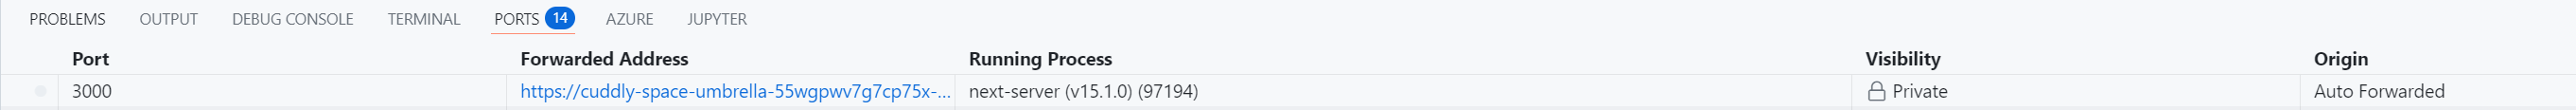

In [ ]:
from flask import Flask, request, jsonify, send_from_directory
from flask_cors import CORS
from langchain.schema import Document
from langchain_openai import AzureChatOpenAI
from langchain_openai import AzureOpenAIEmbeddings
from langchain.schema import StrOutputParser
from langchain.schema.runnable import RunnablePassthrough
from langchain_community.vectorstores import AzureSearch
from langchain_core.prompts import ChatPromptTemplate
import os
import sys
import uuid
import threading
import time
from pathlib import Path
import json
from dotenv import load_dotenv

load_dotenv()

# Load and validate Azure AI Services configs
AZURE_AI_SERVICE_ENDPOINT = os.getenv("AZURE_AI_SERVICE_ENDPOINT")
AZURE_AI_SERVICE_API_VERSION = os.getenv("AZURE_AI_SERVICE_API_VERSION", "2024-12-01-preview")

# Load and validate Azure OpenAI configs
AZURE_OPENAI_ENDPOINT = os.getenv("AZURE_OPENAI_ENDPOINT")
AZURE_OPENAI_CHAT_DEPLOYMENT_NAME = os.getenv("AZURE_OPENAI_CHAT_DEPLOYMENT_NAME")
AZURE_OPENAI_CHAT_API_VERSION = os.getenv("AZURE_OPENAI_CHAT_API_VERSION", "2024-08-01-preview")
AZURE_OPENAI_EMBEDDING_DEPLOYMENT_NAME = os.getenv("AZURE_OPENAI_EMBEDDING_DEPLOYMENT_NAME")
AZURE_OPENAI_EMBEDDING_API_VERSION = os.getenv("AZURE_OPENAI_EMBEDDING_API_VERSION", "2023-05-15")

# Load and validate Azure Search Services configs
AZURE_SEARCH_ENDPOINT = os.getenv("AZURE_SEARCH_ENDPOINT")
INDEX_NAME = os.getenv("AZURE_SEARCH_INDEX_NAME", "sample-index-video")

from azure.identity import DefaultAzureCredential, get_bearer_token_provider
credential = DefaultAzureCredential()
token_provider = get_bearer_token_provider(credential, "https://cognitiveservices.azure.com/.default")

parent_dir = Path(Path.cwd()).parent
sys.path.append(
    str(parent_dir)
)

from python.content_understanding_client import AzureContentUnderstandingClient

app = Flask(__name__)
CORS(app)

# Job tracking system
# Dictionary to store job information
jobs = {}

# Job status constants
JOB_STATUS_PENDING = "pending"
JOB_STATUS_PROCESSING = "processing"
JOB_STATUS_INDEXING = "indexing"
JOB_STATUS_COMPLETED = "completed"
JOB_STATUS_FAILED = "failed"
JOB_STATUS_CANCELLED = "cancelled"

prompt_str = """You are an assistant for finding relevant video segments given a question. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise. If you find a relevant video segment, summarize the details of the segment. Include the startTimeMs and endTimeMs. At the end of your response, output the sas url of the segment verbatim, followed by a space, and followed by the starting time of the segment in integer seconds, don't add parenthesis or any other character before or after the starting time or the url. Make sure the output is URL followed by the starting time, in that order.
Question: {question} 
Context: {context} 
Answer:"""

# Default JSON configuration
DEFAULT_JSON_CONFIG = {
    "analyzerId": "video_cu_analyzer",
    "name": "Video Content Understanding",
    "description": "Generating content understanding from video.",
    "scenario": "videoShot",
    "config": {
        "returnDetails": True,
        "locales": [
            "en-US",
            "es-ES",
            "es-MX",
            "fr-FR",
            "hi-IN",
            "it-IT",
            "ja-JP",
            "ko-KR",
            "pt-BR",
            "zh-CN"
        ],
        "enableFace": False
    },
    "fieldSchema": {
        "name": "Content Understanding",
        "descriptions": "Generate content understanding from video.",
        "fields": {
            "segmentDescription": {
                "type": "string",
                "description": "Detailed summary of the video segment, focusing on people, places, and actions taking place."
            }
        }
    }
}

# Utility functions for JSON processing
def convert_values_to_strings(json_obj):
    return [str(value) for value in json_obj]

def remove_markdown(json_obj):
    for segment in json_obj:
        if 'markdown' in segment:
            del segment['markdown']
    return json_obj

def process_cu_scene_description(scene_description, video_url):
    audio_visual_segments = scene_description["result"]["contents"]
    for segment in audio_visual_segments:
        segment["url"] = video_url
    audio_visual_splits = [json.dumps(v) for v in audio_visual_segments]
    docs = [Document(page_content=v) for v in audio_visual_splits]
    return docs

def embed_and_index_chunks(docs):
    aoai_embeddings = AzureOpenAIEmbeddings(
        azure_deployment=AZURE_OPENAI_EMBEDDING_DEPLOYMENT_NAME,
        openai_api_version=AZURE_OPENAI_EMBEDDING_API_VERSION,  # e.g., "2023-12-01-preview"
        azure_endpoint=AZURE_OPENAI_ENDPOINT,
        azure_ad_token_provider=token_provider
    )

    vector_store: AzureSearch = AzureSearch(
        azure_search_endpoint=AZURE_SEARCH_ENDPOINT,
        azure_search_key=None,
        index_name=INDEX_NAME,
        embedding_function=aoai_embeddings.embed_query,
    )
    vector_store.add_documents(documents=docs)

# RAG
def setup_rag_chain(vector_store):
    retriever = vector_store.as_retriever(search_type="similarity", k=3)

    prompt = ChatPromptTemplate.from_template(prompt_str)
    llm = AzureChatOpenAI(
        openai_api_version=AZURE_OPENAI_CHAT_API_VERSION,  # e.g., "2023-12-01-preview"
        azure_deployment=AZURE_OPENAI_CHAT_DEPLOYMENT_NAME,
        azure_ad_token_provider=token_provider,
        temperature=0.7,
    )

    def format_docs(docs):
        return "\n\n".join(doc.page_content for doc in docs)

    rag_chain = (
        {"context": retriever | format_docs, "question": RunnablePassthrough()}
        | prompt
        | llm
        | StrOutputParser()
    )
    return rag_chain

def conversational_search(query):
    aoai_embeddings = AzureOpenAIEmbeddings(
        azure_deployment=AZURE_OPENAI_EMBEDDING_DEPLOYMENT_NAME,
        openai_api_version=AZURE_OPENAI_EMBEDDING_API_VERSION,  # e.g., "2023-12-01-preview"
        azure_endpoint=AZURE_OPENAI_ENDPOINT,
        azure_ad_token_provider=token_provider
    )

    vector_store: AzureSearch = AzureSearch(
        azure_search_endpoint=AZURE_SEARCH_ENDPOINT,
        azure_search_key=None,
        index_name=INDEX_NAME,
        embedding_function=aoai_embeddings.embed_query,
    )

    rag_chain = setup_rag_chain(vector_store)
    output = rag_chain.invoke(query)
    print(output)
    return output

def similarity_search(query):
    aoai_embeddings = AzureOpenAIEmbeddings(
        azure_deployment=AZURE_OPENAI_EMBEDDING_DEPLOYMENT_NAME,
        openai_api_version=AZURE_OPENAI_EMBEDDING_API_VERSION,  # e.g., "2023-12-01-preview"
        azure_endpoint=AZURE_OPENAI_ENDPOINT,
        azure_ad_token_provider=token_provider
    )

    vector_store: AzureSearch = AzureSearch(
        azure_search_endpoint=AZURE_SEARCH_ENDPOINT,
        azure_search_key=None,
        index_name=INDEX_NAME,
        embedding_function=aoai_embeddings.embed_query,
    )

    docs = vector_store.similarity_search(
        query=query,
        k=3,
        search_type="similarity",
    )
    return docs

def hybrid_search(query):
    aoai_embeddings = AzureOpenAIEmbeddings(
        azure_deployment=AZURE_OPENAI_EMBEDDING_DEPLOYMENT_NAME,
        openai_api_version=AZURE_OPENAI_EMBEDDING_API_VERSION,  # e.g., "2023-12-01-preview"
        azure_endpoint=AZURE_OPENAI_ENDPOINT,
        azure_ad_token_provider=token_provider
    )

    vector_store: AzureSearch = AzureSearch(
        azure_search_endpoint=AZURE_SEARCH_ENDPOINT,
        azure_search_key=None,
        index_name=INDEX_NAME,
        embedding_function=aoai_embeddings.embed_query,
    )

    # Use hybrid search which combines semantic and keyword search
    docs = vector_store.hybrid_search(query=query, k=5)
    return docs

# Process video with Azure Content Understanding
def process_video_with_cu(video_url, analyzer_schema):
    try:
        # Initialize the Azure Content Understanding client
        import uuid
        
        # Process the video URL with the analyzer
        analyzer_id = analyzer_schema.get("analyzerId") + "_" + str(uuid.uuid4())
        print(f"Processing video URL: {video_url} with analyzer ID: {analyzer_id}")
        
        cu_client = AzureContentUnderstandingClient(
            endpoint=AZURE_AI_SERVICE_ENDPOINT,
            api_version=AZURE_AI_SERVICE_API_VERSION,
            token_provider=token_provider,
            x_ms_useragent="azure-ai-content-understanding-python/search_with_video", # This header is used for sample usage telemetry, please comment out this line if you want to opt out.
        )
        print("Azure Content Understanding client initialized")
        response = cu_client.begin_create_analyzer(analyzer_id, analyzer_template=analyzer_schema)
        result = cu_client.poll_result(response)
        print(f"Analyzer created with ID: {analyzer_id}")

        response = cu_client.begin_analyze(analyzer_id, file_location=video_url)
        print(f"Video analysis started with ID: {analyzer_id}")
        video_cu_result = cu_client.poll_result(response, timeout_seconds=36000)
        print(f"Video analysis completed with ID: {analyzer_id}")

        cu_client.delete_analyzer(analyzer_id)
        
        # For now, just return success
        return True, "Video URL processed successfully", video_cu_result
        
    except Exception as e:
        print(f"Error processing video with Azure Content Understanding: {str(e)}")
        return False, f"Failed to process video: {str(e)}", None

# Background job processing function
def process_video_job(job_id, video_url, analyzer_schema):
    try:
        # Update job status to processing
        jobs[job_id]["status"] = JOB_STATUS_PROCESSING
        jobs[job_id]["progress"] = 30
        jobs[job_id]["message"] = "Processing video..."
        
        # Process the video
        success, message, video_cu_result = process_video_with_cu(video_url, analyzer_schema)
        
        if not success:
            jobs[job_id]["status"] = JOB_STATUS_FAILED
            jobs[job_id]["error"] = message
            jobs[job_id]["progress"] = 0
            return
        
        # Update job status to indexing
        jobs[job_id]["status"] = JOB_STATUS_INDEXING
        jobs[job_id]["progress"] = 80
        jobs[job_id]["message"] = "Indexing content..."
        
        # Process and index the results
        try:
            docs = process_cu_scene_description(video_cu_result, video_url)
            embed_and_index_chunks(docs)
            print("Successfully indexed video content")
            
            # Update job status to completed
            jobs[job_id]["status"] = JOB_STATUS_COMPLETED
            jobs[job_id]["progress"] = 100
            jobs[job_id]["message"] = "Processing completed!"
            jobs[job_id]["result"] = {
                "message": "Video indexed with custom analyzer successfully", 
                "data": analyzer_schema,
                "videoUrl": video_url
            }
        except Exception as e:
            print(f"Error processing scene description: {str(e)}")
            jobs[job_id]["status"] = JOB_STATUS_FAILED
            jobs[job_id]["error"] = f"Failed to index content: {str(e)}"
            jobs[job_id]["progress"] = 0
    except Exception as e:
        print(f"Error in job processing: {str(e)}")
        jobs[job_id]["status"] = JOB_STATUS_FAILED
        jobs[job_id]["error"] = f"Job processing error: {str(e)}"
        jobs[job_id]["progress"] = 0
    
    # Check if job was cancelled
    if jobs[job_id]["status"] == JOB_STATUS_CANCELLED:
        print(f"Job {job_id} was cancelled")

# New endpoint for configuration settings
@app.route('/config', methods=['POST'])
def update_config():
    try:
        # No need to process any Azure configuration from the frontend
        # Just return success as the configuration is now read from .env file
        print("Configuration endpoint called - settings are now read from .env file")
        
        return jsonify({'message': 'Configuration settings are now read from environment variables'}), 200
    
    except Exception as e:
        print(f"Error in config endpoint: {str(e)}")
        return jsonify({'error': f'Server error: {str(e)}'}), 500

# Updated search endpoint to support both similarity and hybrid search
@app.route('/search', methods=['POST'])
def search():
    data = request.get_json()
    query = data.get('query', '')
    search_type = data.get('searchType', 'similarity')  # Default to similarity if not specified
    
    print(f"Search query: {query}, Search type: {search_type}")
    
    if not query:
        return jsonify({'error': 'No query provided'}), 400
    
    try:
        # Perform search based on the selected search type
        response = []
        
        if search_type == 'hybrid':
            results = hybrid_search(query)
        else:  # Default to similarity search
            results = similarity_search(query)
            
        if results:
            for res in results:
                page_content = json.loads(res.page_content)
                res_obj = {
                    "startTimeMs": page_content["startTimeMs"],
                    "endTimeMs": page_content["endTimeMs"],
                    "fields": page_content["fields"],
                    "videoUrl": page_content.get("url", "")  # Include the video URL in the response
                }
                response.append(res_obj)
        print(f"Found {len(response)} results")
        
        return jsonify({
            'results': response,
            'searchType': search_type
        }), 200
    except Exception as e:
        print(f"Search error: {str(e)}")
        return jsonify({'error': f'Search failed: {str(e)}'}), 500

conversations = []
# Endpoint for chat
@app.route('/chat', methods=['POST'])
def chat():
    data = request.get_json()
    user_message = data.get('message', '')

    reply = conversational_search(user_message)
    ai_reply = f"{reply}"  # Replace with real AI integration.

    # Save this message pair in memory.
    conversations.append({
        'user': user_message,
        'ai': ai_reply
    })

    return jsonify({
        'reply': ai_reply
    })

# New endpoint to start a video processing job
@app.route('/upload/start', methods=['POST'])
def start_upload_job():
    if 'jsonFile' not in request.files:
        return jsonify({'error': 'No JSON file provided'}), 400
    
    file = request.files['jsonFile']
    video_url = str(request.form.get('videoUrl', ''))
    
    if file.filename == '':
        return jsonify({'error': 'No selected file'}), 400
    
    if not video_url:
        return jsonify({'error': 'No video URL provided'}), 400
    
    # Check if settings are configured
    if not all([
        AZURE_OPENAI_EMBEDDING_DEPLOYMENT_NAME,
        AZURE_OPENAI_EMBEDDING_API_VERSION,
        AZURE_OPENAI_ENDPOINT,
        AZURE_OPENAI_CHAT_DEPLOYMENT_NAME,
        AZURE_OPENAI_CHAT_API_VERSION,
        AZURE_SEARCH_ENDPOINT,
        INDEX_NAME,
        AZURE_AI_SERVICE_ENDPOINT,
        AZURE_AI_SERVICE_API_VERSION,
    ]):
        return jsonify({'error': 'Configuration settings must be set before uploading files'}), 400
    
    try:
        # Process JSON file
        json_data = json.load(file)
        print(json.dumps(json_data, indent=2))  # Print the received JSON object
        
        # Validate the JSON structure
        required_fields = ["analyzerId", "name", "description", "scenario", "config", "fieldSchema"]
        missing_fields = [field for field in required_fields if field not in json_data]
        
        if missing_fields:
            return jsonify({
                'error': f'Invalid JSON format. Missing required fields: {", ".join(missing_fields)}'
            }), 400
        
        # Create a new job ID
        job_id = str(uuid.uuid4())
        
        # Store job information
        jobs[job_id] = {
            "status": JOB_STATUS_PENDING,
            "progress": 10,
            "message": "Job created, waiting to start...",
            "videoUrl": video_url,
            "analyzer_schema": json_data,
            "created_at": time.time(),
            "updated_at": time.time()
        }
        
        # Start a background thread to process the job
        thread = threading.Thread(
            target=process_video_job,
            args=(job_id, video_url, json_data)
        )
        thread.daemon = True
        thread.start()
        
        return jsonify({
            "jobId": job_id,
            "message": "Video processing job started",
            "status": JOB_STATUS_PENDING
        }), 202
        
    except json.JSONDecodeError:
        return jsonify({'error': 'Invalid JSON format'}), 400
    except Exception as e:
        print(f"Error starting upload job: {str(e)}")
        return jsonify({'error': f'Failed to start upload job: {str(e)}'}), 500

# Endpoint to check job status
@app.route('/upload/status/<job_id>', methods=['GET'])
def check_job_status(job_id):
    if job_id not in jobs:
        return jsonify({
            "error": "Job not found"
        }), 404
    
    job = jobs[job_id]
    
    # Update the last accessed time
    job["updated_at"] = time.time()
    
    response = {
        "status": job["status"],
        "progress": job["progress"],
        "message": job.get("message", "")
    }
    
    # Add result if job is completed
    if job["status"] == JOB_STATUS_COMPLETED and "result" in job:
        response["result"] = job["result"]
    
    # Add error if job failed
    if job["status"] == JOB_STATUS_FAILED and "error" in job:
        response["error"] = job["error"]
    
    return jsonify(response), 200

# Endpoint to cancel a job
@app.route('/upload/cancel/<job_id>', methods=['POST'])
def cancel_job(job_id):
    if job_id not in jobs:
        return jsonify({
            "error": "Job not found"
        }), 404
    
    job = jobs[job_id]
    
    # Only allow cancellation of pending or processing jobs
    if job["status"] not in [JOB_STATUS_PENDING, JOB_STATUS_PROCESSING, JOB_STATUS_INDEXING]:
        return jsonify({
            "error": f"Cannot cancel job with status: {job['status']}"
        }), 400
    
    # Mark the job as cancelled
    job["status"] = JOB_STATUS_CANCELLED
    job["message"] = "Job cancelled by user"
    job["updated_at"] = time.time()
    
    return jsonify({
        "message": "Job cancelled successfully",
        "jobId": job_id
    }), 200

# Maintain the original upload endpoint for backward compatibility
@app.route('/upload', methods=['POST'])
def upload_json():
    if 'jsonFile' not in request.files:
        return jsonify({'error': 'No JSON file provided'}), 400
    
    file = request.files['jsonFile']
    video_url = str(request.form.get('videoUrl', ''))
    
    if file.filename == '':
        return jsonify({'error': 'No selected file'}), 400
    
    if not video_url:
        return jsonify({'error': 'No video URL provided'}), 400
    
    # Check if settings are configured
    if not all([
        AZURE_OPENAI_EMBEDDING_DEPLOYMENT_NAME,
        AZURE_OPENAI_EMBEDDING_API_VERSION,
        AZURE_OPENAI_ENDPOINT,
        AZURE_OPENAI_CHAT_DEPLOYMENT_NAME,
        AZURE_OPENAI_CHAT_API_VERSION,
        AZURE_SEARCH_ENDPOINT,
        INDEX_NAME,
        AZURE_AI_SERVICE_ENDPOINT,
        AZURE_AI_SERVICE_API_VERSION,
    ]):
        return jsonify({'error': 'Configuration settings must be set before uploading files'}), 400
    
    try:
        # Process JSON file
        json_data = json.load(file)
        print(json.dumps(json_data, indent=2))  # Print the received JSON object
        
        # Validate the JSON structure
        required_fields = ["analyzerId", "name", "description", "scenario", "config", "fieldSchema"]
        missing_fields = [field for field in required_fields if field not in json_data]
        
        if missing_fields:
            return jsonify({
                'error': f'Invalid JSON format. Missing required fields: {", ".join(missing_fields)}'
            }), 400
        
        # Process the video with Azure Content Understanding
        success, message, video_cu_result = process_video_with_cu(video_url, json_data)
        
        if not success:
            return jsonify({'error': message}), 500
        
        # Process the JSON data if needed
        # If this is a scene description, process it and index it
        try:
            docs = process_cu_scene_description(video_cu_result, video_url)
            embed_and_index_chunks(docs)
            print("Successfully indexed video content")
            return jsonify({
                "message": "Video indexed with custom analyzer successfully", 
                "data": json_data,
                "videoUrl": video_url
            }), 200
        except Exception as e:
            print(f"Error processing scene description: {str(e)}")
            # If it's not a scene description or there's an error, just return the JSON
            return jsonify({
                "message": "JSON configuration and video URL received", 
                "data": json_data,
                "videoUrl": video_url
            }), 200
    except json.JSONDecodeError:
        return jsonify({'error': 'Invalid JSON format'}), 400
    except Exception as e:
        print(f"Error processing upload: {str(e)}")
        return jsonify({'error': f'Failed to process upload: {str(e)}'}), 500

# Job cleanup task
def cleanup_old_jobs():
    """Remove completed, failed, or cancelled jobs older than 24 hours"""
    current_time = time.time()
    jobs_to_remove = []
    
    for job_id, job in jobs.items():
        # Keep jobs for 24 hours (86400 seconds)
        if job["status"] in [JOB_STATUS_COMPLETED, JOB_STATUS_FAILED, JOB_STATUS_CANCELLED]:
            if current_time - job.get("updated_at", 0) > 86400:
                jobs_to_remove.append(job_id)
    
    for job_id in jobs_to_remove:
        del jobs[job_id]
    
    print(f"Cleaned up {len(jobs_to_remove)} old jobs")

# Start a background thread for job cleanup
def start_cleanup_thread():
    while True:
        try:
            cleanup_old_jobs()
        except Exception as e:
            print(f"Error in cleanup thread: {str(e)}")
        
        # Run cleanup every hour
        time.sleep(3600)

# Start the cleanup thread when the app starts
cleanup_thread = threading.Thread(target=start_cleanup_thread)
cleanup_thread.daemon = True
cleanup_thread.start()

if __name__ == '__main__':
    from werkzeug.serving import run_simple
    run_simple('localhost', 9020, app)


Make sure you set the port 9020 visibility to public!
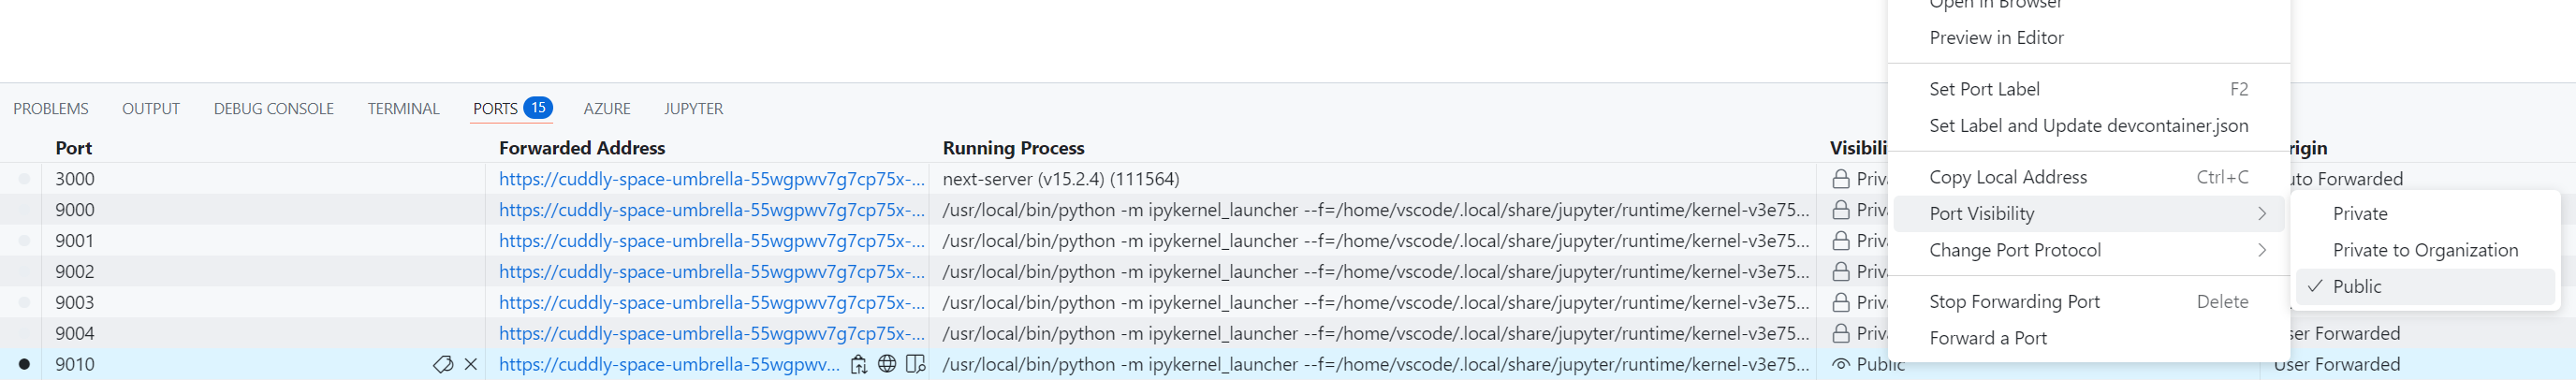

If you are in codespace, find the forwarded address for the 9020 port, for example: `https://miniature-adventure-q6w7gwvgqphx9jx-9020.app.github.dev/`, copy and paste the url here:
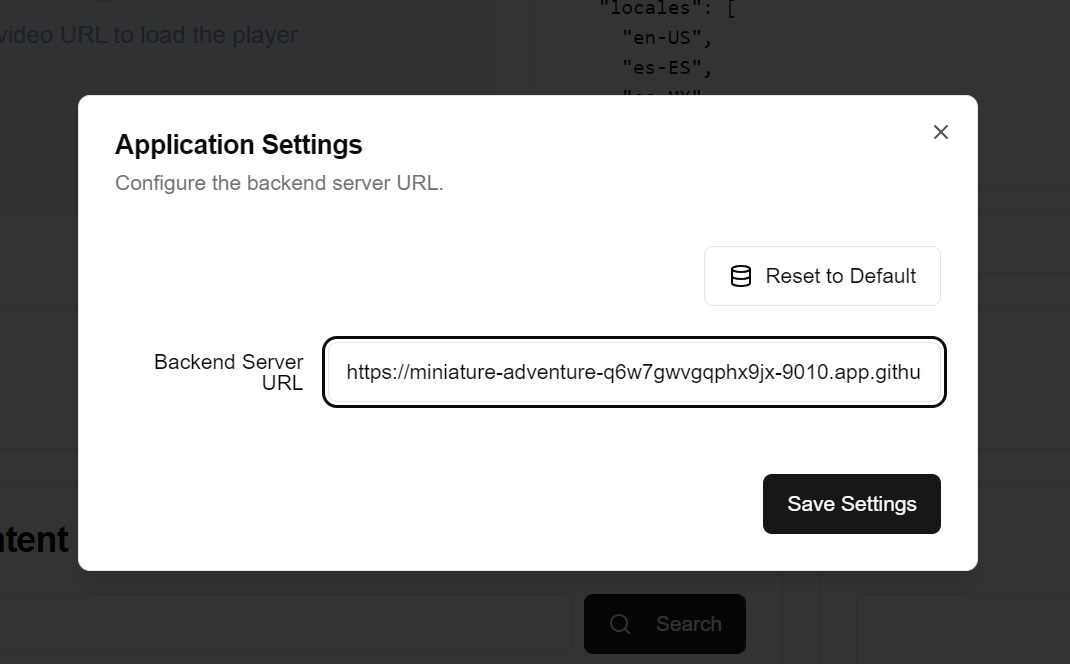

If you are hosting locally, you can just use the localhost address instead: `http://localhost:9020`

If you get the error "Address already in use" use this command: `kill -9 $(lsof -t -i:"9020")`

If you get auth issues, make sure to `az login --use-device-code` or `azd auth login`